In [11]:
import csv
import os
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms, models, datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim

device = "cuda" if torch.cuda.is_available() else "cpu"
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data.sampler import SubsetRandomSampler
import tkinter as tk
from tkinter import filedialog

In [12]:
root = tk.Tk()
root.withdraw()

TRAIN_DATA_DIR = filedialog.askdirectory(
    title="Select folder containing images for training"
)
print(TRAIN_DATA_DIR)
TRAIN_CSV_PATH = "../train.csv"
MODEL_PATH = "../model/"
BATCH_SIZE = 32
DROPOUT = 0.2
VALIDATION_SPLIT = 0.2
SEED = 42

C:/Users/u7oh2m/WorkingStudent/Personal/GitHub/aiornot/train


# Training

In [13]:
class ImageData(Dataset):
    def __init__(self, folder):
        ai_images = []
        not_ai_images = []
        with open(TRAIN_CSV_PATH, mode="r") as infile:
            next(infile)  # Skip the header
            reader = csv.reader(infile, skipinitialspace=True)
            result = dict(reader)

        ai_images = [folder + "/" + k for k, v in result.items() if v == "1"]
        not_ai_images = [
            folder + "/" + k for k, v in result.items() if v == "0"
        ]
        # print(len(ai_images))
        # print(len(not_ai_images))
        # print(ai_images[:5])
        # print(not_ai_images[:5])

        self.fpaths = ai_images[:500] + not_ai_images[:500]

        # self.fpaths = ai_images + not_ai_images

        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )
        from random import shuffle, seed

        seed(10)
        shuffle(self.fpaths)
        self.targets = [
            torch.tensor(int(result[fpath.split("/")[-1]]))
            for fpath in self.fpaths
        ]
        self.targets = torch.Tensor(self.targets)
        self.targets = nn.functional.one_hot(self.targets.long(), 2)
        # print(self.fpaths[:10], self.targets[:10])
        # print(len(self.fpaths), len(self.targets))

    def __len__(self):
        return len(self.fpaths)

    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = cv2.imread(f)[:, :, ::-1]
        im = cv2.resize(im, (224, 224))
        im = torch.tensor(im / 255)
        im = im.permute(2, 0, 1)
        im = self.normalize(im)
        return im.float().to(device), target.float().to(device)

In [14]:
def get_model():
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    model.fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(DROPOUT),
        nn.Linear(128, 2),
    )
    # loss_fn = nn.CrossEntropyLoss()
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    return model.to(device), loss_fn, optimizer

In [15]:
from torchsummary import summary

model, loss_fn, optimizer = get_model()
# summary(model, torch.zeros(1,3,224,224))

In [16]:
from sklearn.metrics import log_loss


def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [17]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    prediction = torch.argmax(prediction, dim=1)
    y = torch.argmax(y, dim=1)
    is_correct = prediction == y
    return is_correct.cpu().numpy().tolist()

In [18]:
from sklearn.model_selection import train_test_split


def get_data():
    train = ImageData(TRAIN_DATA_DIR)
    # generate indices: instead of the actual data we pass in integers instead
    train_indices, val_indices, _, _ = train_test_split(
        range(len(train)),
        train.targets,
        stratify=train.targets,
        test_size=VALIDATION_SPLIT,
        random_state=SEED,
    )
    # generate subset based on indices
    train_split = Subset(train, train_indices)
    val_split = Subset(train, val_indices)

    # create batches
    trn_dl = DataLoader(
        train_split, batch_size=BATCH_SIZE, shuffle=True, drop_last=True
    )
    val_dl = DataLoader(val_split, batch_size=BATCH_SIZE, drop_last=True)

    return (
        trn_dl,
        (1 - VALIDATION_SPLIT) * len(train),
        val_dl,
        VALIDATION_SPLIT * len(train),
    )

In [19]:
trn_dl, trn_dl_len, val_dl, val_dl_len = get_data()
print(trn_dl_len, val_dl_len)
model, loss_fn, optimizer = get_model()


800.0 200.0


c:\Users\u7oh2m\Anaconda3\envs\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\u7oh2m\Anaconda3\envs\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
n_train_batches = trn_dl_len // BATCH_SIZE
n_val_batches = val_dl_len // BATCH_SIZE
train_losses, train_accuracies = [], []
val_accuracies = []
for epoch in range(5):
    n_train_batches_remaining = n_train_batches
    print(f" epoch {epoch + 1}/5")
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
        if n_train_batches_remaining % 100 == 0:
            print(n_train_batches_remaining, "training batches remaining")
        n_train_batches_remaining = n_train_batches_remaining - 1
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

 epoch 1/5
 epoch 2/5
 epoch 3/5
 epoch 4/5
 epoch 5/5


[0.85125, 0.87125, 0.8725, 0.86875, 0.89375]
[0.875, 0.8802083333333334, 0.8645833333333334, 0.875, 0.8645833333333334]


C:\Users\u7oh2m\AppData\Local\Temp\ipykernel_8108\2306964317.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


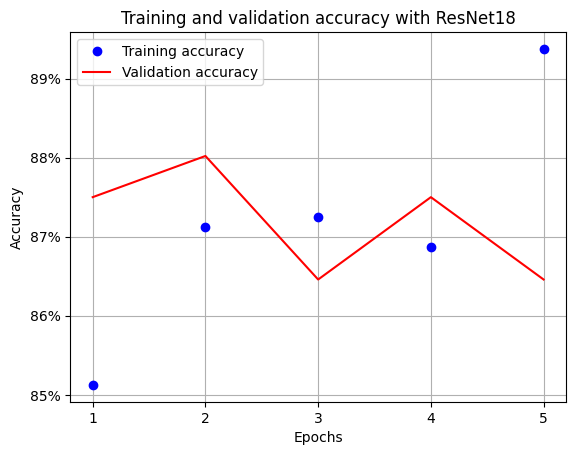

In [21]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
print(train_accuracies)
print(val_accuracies)
%matplotlib inline
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with ResNet18')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# plt.ylim(0.95,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [22]:
torch.save(model, MODEL_PATH + "model_resenet18.pt")
